In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

print("TensorFlow version:", tf.__version__)


TensorFlow version: 2.19.0


In [4]:
def scaled_dot_product_attention(q, k, v, mask=None):
    """
    q, k, v shape: (..., seq_len, depth)
    mask shape: broadcastable to (..., seq_len_q, seq_len_k)

    returns:
    output: (..., seq_len_q, depth)
    attention_weights: (..., seq_len_q, seq_len_k)
    """
    matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_q, seq_k)

    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_logits = matmul_qk / tf.math.sqrt(dk)

    if mask is not None:
        scaled_logits += (mask * -1e9)

    attention_weights = tf.nn.softmax(scaled_logits, axis=-1)
    output = tf.matmul(attention_weights, v)

    return output, attention_weights

In [5]:
batch, seq_len, depth = 2, 5, 8

q = tf.random.normal((batch, seq_len, depth))
k = tf.random.normal((batch, seq_len, depth))
v = tf.random.normal((batch, seq_len, depth))

output, attn = scaled_dot_product_attention(q, k, v)

print("Output shape:", output.shape)
print("Attention shape:", attn.shape)


Output shape: (2, 5, 8)
Attention shape: (2, 5, 5)


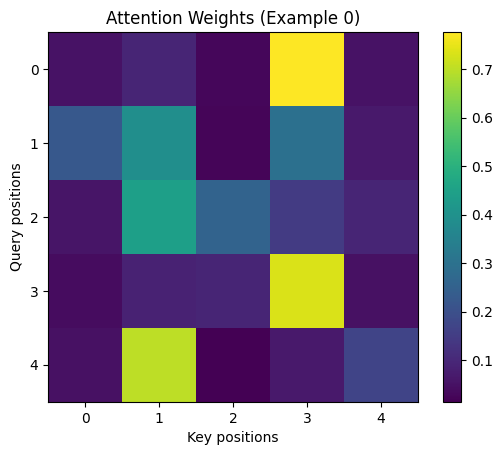

In [6]:
plt.imshow(attn[0])
plt.title("Attention Weights (Example 0)")
plt.xlabel("Key positions")
plt.ylabel("Query positions")
plt.colorbar()
plt.show()


In [7]:
d_model = 128
num_heads = 4

mha = tf.keras.layers.MultiHeadAttention(
    num_heads=num_heads,
    key_dim=d_model // num_heads
)

# Fake input: (batch, seq_len, d_model)
x = tf.random.normal((2, 6, d_model))

# Self-attention: query=key=value=x
out = mha(query=x, value=x, key=x)

print("Input shape:", x.shape)
print("Output shape:", out.shape)

Input shape: (2, 6, 128)
Output shape: (2, 6, 128)


In [8]:
def positional_encoding(seq_len, d_model):
    pos = np.arange(seq_len)[:, np.newaxis]   # (seq_len, 1)
    i = np.arange(d_model)[np.newaxis, :]     # (1, d_model)

    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
    angle_rads = pos * angle_rates

    pe = np.zeros((seq_len, d_model))
    pe[:, 0::2] = np.sin(angle_rads[:, 0::2])
    pe[:, 1::2] = np.cos(angle_rads[:, 1::2])

    return tf.cast(pe[np.newaxis, ...], dtype=tf.float32)  # (1, seq_len, d_model)


Positional Encoding shape: (1, 50, 128)


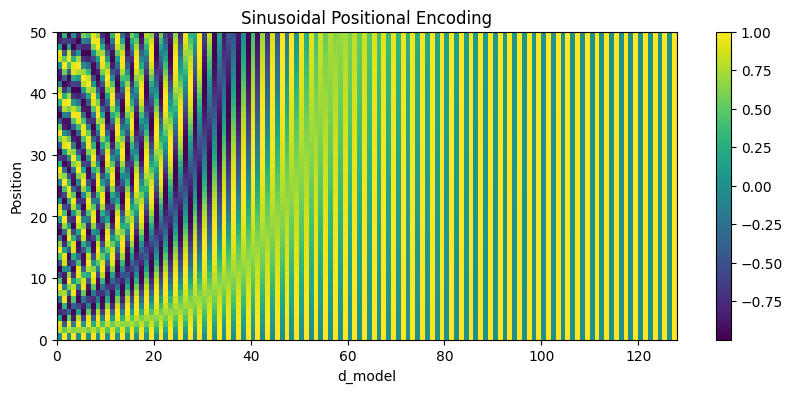

In [9]:
pe = positional_encoding(seq_len=50, d_model=128)

print("Positional Encoding shape:", pe.shape)

plt.figure(figsize=(10,4))
plt.pcolormesh(pe[0], shading='auto')
plt.xlabel("d_model")
plt.ylabel("Position")
plt.title("Sinusoidal Positional Encoding")
plt.colorbar()
plt.show()


In [10]:
class TokenAndPositionEmbedding(tf.keras.layers.Layer):
    def __init__(self, vocab_size, d_model, max_len=200, dropout=0.1):
        super().__init__()
        self.d_model = d_model
        self.token_emb = tf.keras.layers.Embedding(vocab_size, d_model)
        self.pos_enc = positional_encoding(max_len, d_model)
        self.dropout = tf.keras.layers.Dropout(dropout)

    def call(self, x, training=False):
        seq_len = tf.shape(x)[1]
        x = self.token_emb(x)  # (batch, seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))  # scale like paper
        x = x + self.pos_enc[:, :seq_len, :]
        return self.dropout(x, training=training)

In [11]:
vocab_size = 1000
embed_layer = TokenAndPositionEmbedding(vocab_size=vocab_size, d_model=128)

tokens = tf.random.uniform((2, 10), maxval=vocab_size, dtype=tf.int32)
emb = embed_layer(tokens)

print("Tokens shape:", tokens.shape)
print("Embedding shape:", emb.shape)


Tokens shape: (2, 10)
Embedding shape: (2, 10, 128)


In [12]:
class FeedForward(tf.keras.layers.Layer):
    def __init__(self, d_model=128, d_ff=512, dropout=0.1):
        super().__init__()
        self.fc1 = tf.keras.layers.Dense(d_ff, activation="relu")
        self.fc2 = tf.keras.layers.Dense(d_model)
        self.dropout = tf.keras.layers.Dropout(dropout)

    def call(self, x, training=False):
        x = self.fc1(x)
        x = self.dropout(x, training=training)
        x = self.fc2(x)
        return x


In [13]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model=128, num_heads=4, d_ff=512, dropout=0.1):
        super().__init__()

        self.norm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.mha = tf.keras.layers.MultiHeadAttention(
            num_heads=num_heads,
            key_dim=d_model // num_heads,
            dropout=dropout
        )

        self.ffn = FeedForward(d_model, d_ff, dropout)

        self.dropout1 = tf.keras.layers.Dropout(dropout)
        self.dropout2 = tf.keras.layers.Dropout(dropout)

    def call(self, x, training=False, mask=None):
        # 1) Pre-norm + Self-attention + residual
        x_norm = self.norm1(x)
        attn_out = self.mha(query=x_norm, value=x_norm, key=x_norm, attention_mask=mask, training=training)
        attn_out = self.dropout1(attn_out, training=training)
        x = x + attn_out

        # 2) Pre-norm + FFN + residual
        x_norm = self.norm2(x)
        ffn_out = self.ffn(x_norm, training=training)
        ffn_out = self.dropout2(ffn_out, training=training)
        x = x + ffn_out

        return x


In [14]:
encoder_layer = EncoderLayer(d_model=128, num_heads=4, d_ff=512)

x = tf.random.normal((2, 10, 128))  # (batch, seq_len, d_model)
out = encoder_layer(x, training=False)

print("Input shape:", x.shape)
print("Output shape:", out.shape)


Input shape: (2, 10, 128)
Output shape: (2, 10, 128)


In [15]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, vocab_size, d_model=128, num_heads=4, d_ff=512, num_layers=2, max_len=200, dropout=0.1):
        super().__init__()
        self.embedding = TokenAndPositionEmbedding(vocab_size, d_model, max_len, dropout)
        self.layers = [EncoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)]
        self.norm = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    def call(self, x, training=False, mask=None):
        x = self.embedding(x, training=training)

        for layer in self.layers:
            x = layer(x, training=training, mask=mask)

        return self.norm(x)


In [16]:
vocab_size = 2000
encoder = Encoder(vocab_size=vocab_size)

tokens = tf.random.uniform((2, 12), maxval=vocab_size, dtype=tf.int32)
enc_out = encoder(tokens)

print("Input tokens:", tokens.shape)
print("Encoder output:", enc_out.shape)


Input tokens: (2, 12)
Encoder output: (2, 12, 128)


In [17]:
def create_look_ahead_mask(seq_len):
    # (seq_len, seq_len)
    mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    return mask  # 1s above diagonal, 0s elsewhere


In [18]:
mask = create_look_ahead_mask(6)
print(mask.numpy())


[[0. 1. 1. 1. 1. 1.]
 [0. 0. 1. 1. 1. 1.]
 [0. 0. 0. 1. 1. 1.]
 [0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0.]]


In [19]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model=128, num_heads=4, d_ff=512, dropout=0.1):
        super().__init__()

        self.norm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.self_mha = tf.keras.layers.MultiHeadAttention(
            num_heads=num_heads,
            key_dim=d_model // num_heads,
            dropout=dropout
        )

        self.cross_mha = tf.keras.layers.MultiHeadAttention(
            num_heads=num_heads,
            key_dim=d_model // num_heads,
            dropout=dropout
        )

        self.ffn = FeedForward(d_model, d_ff, dropout)

        self.dropout1 = tf.keras.layers.Dropout(dropout)
        self.dropout2 = tf.keras.layers.Dropout(dropout)
        self.dropout3 = tf.keras.layers.Dropout(dropout)

    def call(self, x, enc_out, training=False, look_ahead_mask=None, padding_mask=None):
        """
        x: (batch, target_seq_len, d_model)
        enc_out: (batch, source_seq_len, d_model)
        look_ahead_mask: (target_seq_len, target_seq_len) or broadcastable
        padding_mask: optional for cross-attn (not used yet but good to include)
        """

        # 1) Masked Self-Attention
        x_norm = self.norm1(x)
        attn1 = self.self_mha(
            query=x_norm, value=x_norm, key=x_norm,
            attention_mask=look_ahead_mask,
            training=training
        )
        attn1 = self.dropout1(attn1, training=training)
        x = x + attn1

        # 2) Cross-Attention (Decoder attends to Encoder output)
        x_norm = self.norm2(x)
        attn2 = self.cross_mha(
            query=x_norm, value=enc_out, key=enc_out,
            attention_mask=padding_mask,
            training=training
        )
        attn2 = self.dropout2(attn2, training=training)
        x = x + attn2

        # 3) Feed Forward
        x_norm = self.norm3(x)
        ffn_out = self.ffn(x_norm, training=training)
        ffn_out = self.dropout3(ffn_out, training=training)
        x = x + ffn_out

        return x


In [20]:
decoder_layer = DecoderLayer(d_model=128, num_heads=4, d_ff=512)

batch = 2
src_len = 8
tgt_len = 6
d_model = 128

x = tf.random.normal((batch, tgt_len, d_model))       # decoder input embeddings
enc_out = tf.random.normal((batch, src_len, d_model)) # encoder output

look_ahead_mask = create_look_ahead_mask(tgt_len)

out = decoder_layer(x, enc_out, look_ahead_mask=look_ahead_mask)

print("Decoder input:", x.shape)
print("Encoder output:", enc_out.shape)
print("Decoder output:", out.shape)


Decoder input: (2, 6, 128)
Encoder output: (2, 8, 128)
Decoder output: (2, 6, 128)


In [21]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, vocab_size, d_model=128, num_heads=4, d_ff=512, num_layers=2, max_len=200, dropout=0.1):
        super().__init__()
        self.embedding = TokenAndPositionEmbedding(vocab_size, d_model, max_len, dropout)
        self.layers = [DecoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)]
        self.norm = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    def call(self, x, enc_out, training=False, look_ahead_mask=None, padding_mask=None):
        x = self.embedding(x, training=training)

        for layer in self.layers:
            x = layer(x, enc_out, training=training,
                      look_ahead_mask=look_ahead_mask,
                      padding_mask=padding_mask)

        return self.norm(x)


In [22]:
tgt_vocab_size = 2000
decoder = Decoder(vocab_size=tgt_vocab_size)

tgt_tokens = tf.random.uniform((2, 7), maxval=tgt_vocab_size, dtype=tf.int32)
enc_out = tf.random.normal((2, 10, 128))

look_ahead_mask = create_look_ahead_mask(tf.shape(tgt_tokens)[1])

dec_out = decoder(tgt_tokens, enc_out, look_ahead_mask=look_ahead_mask)

print("Target tokens:", tgt_tokens.shape)
print("Encoder output:", enc_out.shape)
print("Decoder output:", dec_out.shape)


Target tokens: (2, 7)
Encoder output: (2, 10, 128)
Decoder output: (2, 7, 128)


In [23]:
class Transformer(tf.keras.Model):
    def __init__(self, src_vocab_size, tgt_vocab_size, d_model=128, num_heads=4, d_ff=512, num_layers=2, max_len=200, dropout=0.1):
        super().__init__()
        self.encoder = Encoder(src_vocab_size, d_model, num_heads, d_ff, num_layers, max_len, dropout)
        self.decoder = Decoder(tgt_vocab_size, d_model, num_heads, d_ff, num_layers, max_len, dropout)
        self.final_layer = tf.keras.layers.Dense(tgt_vocab_size)

    def call(self, src, tgt, training=False):
        """
        src: (batch, src_len)
        tgt: (batch, tgt_len)
        """
        enc_out = self.encoder(src, training=training)

        tgt_len = tf.shape(tgt)[1]
        look_ahead_mask = create_look_ahead_mask(tgt_len)

        dec_out = self.decoder(tgt, enc_out, training=training, look_ahead_mask=look_ahead_mask)

        logits = self.final_layer(dec_out)  # (batch, tgt_len, tgt_vocab_size)
        return logits


In [24]:
PAD = 0
START = 1
END = 2

def generate_copy_data(num_samples=20000, seq_len=10, vocab_size=100):
    """
    Generates random sequences and makes target = input.
    """
    X = np.random.randint(3, vocab_size, size=(num_samples, seq_len))
    Y = X.copy()
    return X, Y

# settings
src_vocab_size = 100
tgt_vocab_size = 100
seq_len = 10

X, Y = generate_copy_data(num_samples=20000, seq_len=seq_len, vocab_size=src_vocab_size)

print("X shape:", X.shape)
print("Y shape:", Y.shape)
print("Example:", X[0], "->", Y[0])


X shape: (20000, 10)
Y shape: (20000, 10)
Example: [87 43 24 71 95 70 39 88  7 18] -> [87 43 24 71 95 70 39 88  7 18]


In [25]:
def make_decoder_inputs(targets):
    # targets: (batch, seq_len)
    start_tokens = np.full((targets.shape[0], 1), START)
    dec_inputs = np.concatenate([start_tokens, targets[:, :-1]], axis=1)
    return dec_inputs

dec_inputs = make_decoder_inputs(Y)
print("Decoder input example:", dec_inputs[0])
print("Target example:", Y[0])


Decoder input example: [ 1 87 43 24 71 95 70 39 88  7]
Target example: [87 43 24 71 95 70 39 88  7 18]


In [26]:
batch_size = 64

dataset = tf.data.Dataset.from_tensor_slices((X, dec_inputs, Y))
dataset = dataset.shuffle(20000).batch(batch_size).prefetch(tf.data.AUTOTUNE)

# split
train_size = int(0.9 * len(X))
train_ds = dataset.take(train_size // batch_size)
val_ds = dataset.skip(train_size // batch_size)


In [27]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

def compute_loss(y_true, y_pred):
    # y_true: (batch, seq_len)
    # y_pred: (batch, seq_len, vocab)
    loss = loss_fn(y_true, y_pred)
    return loss


In [28]:
transformer = Transformer(
    src_vocab_size=src_vocab_size,
    tgt_vocab_size=tgt_vocab_size,
    d_model=128,
    num_heads=4,
    d_ff=512,
    num_layers=2,
    max_len=200,
    dropout=0.1
)

@tf.function
def train_step(src, dec_inp, tgt):
    with tf.GradientTape() as tape:
        logits = transformer(src, dec_inp, training=True)
        loss = compute_loss(tgt, logits)

    gradients = tape.gradient(loss, transformer.trainable_variables)
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
    return loss

@tf.function
def val_step(src, dec_inp, tgt):
    logits = transformer(src, dec_inp, training=False)
    loss = compute_loss(tgt, logits)
    return loss

# Train
epochs = 5

for epoch in range(epochs):
    total_loss = 0
    batches = 0

    for src, dec_inp, tgt in train_ds:
        loss = train_step(src, dec_inp, tgt)
        total_loss += loss
        batches += 1

    val_loss = 0
    val_batches = 0
    for src, dec_inp, tgt in val_ds:
        loss = val_step(src, dec_inp, tgt)
        val_loss += loss
        val_batches += 1

    print(f"Epoch {epoch+1} | Train Loss: {total_loss/batches:.4f} | Val Loss: {val_loss/val_batches:.4f}")


Epoch 1 | Train Loss: 0.8895 | Val Loss: 0.0022
Epoch 2 | Train Loss: 0.0067 | Val Loss: 0.0005
Epoch 3 | Train Loss: 0.0059 | Val Loss: 0.0002
Epoch 4 | Train Loss: 0.0033 | Val Loss: 0.0023
Epoch 5 | Train Loss: 0.0040 | Val Loss: 0.0001


In [29]:
def greedy_decode(model, src, max_len=10):
    """
    src: (1, seq_len)
    returns predicted tokens (1, max_len)
    """
    output = [START]

    for i in range(max_len):
        dec_inp = tf.constant([output], dtype=tf.int32)
        logits = model(src, dec_inp, training=False)
        next_token_logits = logits[:, -1, :]
        next_token = tf.argmax(next_token_logits, axis=-1).numpy()[0]
        output.append(int(next_token))

    return output[1:]  # drop START


# Try one example
idx = np.random.randint(0, len(X))
src_example = tf.constant([X[idx]], dtype=tf.int32)

prediction = greedy_decode(transformer, src_example, max_len=seq_len)

print("SRC:", X[idx])
print("PRED:", prediction)
print("TRUE:", Y[idx])


/usr/local/lib/python3.12/dist-packages/keras/src/ops/nn.py:944: UserWarning: You are using a softmax over axis 3 of a tensor of shape (1, 4, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


SRC: [54 55 24 62 10 46 64 74 33 31]
PRED: [54, 54, 62, 45, 62, 46, 64, 33, 31, 31]
TRUE: [54 55 24 62 10 46 64 74 33 31]
